In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds_atm = xr.open_mfdataset('/glade/scratch/czarakas/archive/coupled_BGC_defParams_SpinUp_001/atm/hist/*.h1.*.nc')

In [3]:
ds_lnd = xr.open_mfdataset('/glade/scratch/czarakas/archive/coupled_BGC_defParams_SpinUp_001/lnd/hist/*.h1.*.nc')

# Fix the times 
CESM saves the time as the last time over which something was averaged (e.g. average temperature in January is saved at midnight of Feb 1), so offset by 15 days so the month corresponds to the month over which it was averaged
Only change the time once or else just shifting back 15 days over and over

In [4]:
ds_atm['time']=ds_atm.time.values-datetime.timedelta(days=15)

In [5]:
ds_lnd['time']=ds_lnd.time.values-datetime.timedelta(days=15)

# Calculate area weights

In [35]:
#Atmosphere weights
weight_factor2 = ds_atm.gw / ds_atm.gw.mean(dim='lat')

def atm_weights_region(minlat=-100,maxlat=100):
    gw=ds_atm.gw
    gw=gw.where(gw.lat>=minlat).where(gw.lat<=maxlat)
    return gw/gw.mean(dim='lat')

#Land weights
land_area=ds_lnd.area*ds_lnd.landfrac
landweights = land_area/land_area.sum(dim=['lat','lon'])

#Land weights
def land_weights_region(minlat=-100,maxlat=100):
    land_area=ds_lnd.area*ds_lnd.landfrac
    land_area=land_area.where(land_area.lat>=minlat).where(land_area.lat<=maxlat)
    landweights = land_area/land_area.sum(dim=['lat','lon'])
    return landweights

# Check that CO_2 isn't changing over time (it should be constant!) and that it is about the right concentration
Should be ~388.72 (from Meinshausen et al. 2017)
Check this is true for both the atmosphere AND the land

Text(0, 0.5, 'CO2 concentration (ppm)')

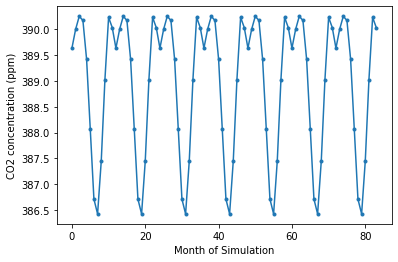

In [7]:
plt.plot(ds_atm.co2vmr*1e6,'.-')
plt.xlabel('Month of Simulation')
plt.ylabel('CO2 concentration (ppm)')

Text(0, 0.5, 'CO2 concentration (ppm)')

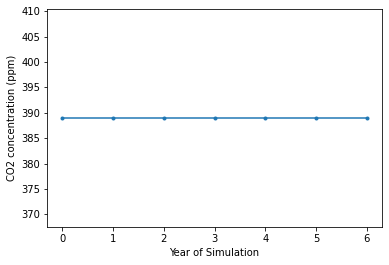

In [8]:
plt.plot(ds_atm.co2vmr.groupby('time.year').mean()*1e6,'.-')
plt.xlabel('Year of Simulation')
plt.ylabel('CO2 concentration (ppm)')

# Look at temperature

In [27]:
tmonths = np.arange(0, np.size(ds_atm.time))/12
tyears = np.arange(0, np.size(ds_atm.time.groupby('time.year').mean(dim='time')))+0.5

Text(0, 0.5, 'Global average surface temperature (C)')

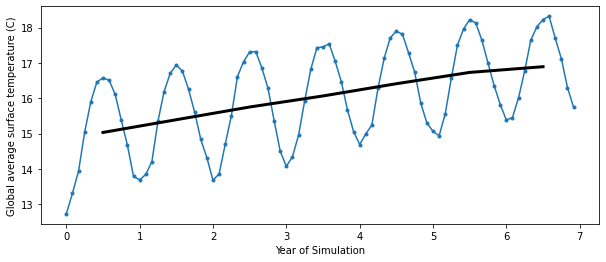

In [29]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, (ds_atm.TS * weight_factor2).mean(dim=('lon', 'lat'))-273.15,'.-')
plt.plot(tyears,(ds_atm.TS * weight_factor2).mean(dim=('lon', 'lat')).groupby('time.year').mean(dim='time')-273.15,
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average surface temperature (C)')

# Look at atmospheric quantities in different latitudinal belts

In [ ]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    weights_region=atm_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_var=(ds_atm.TS*weights_region).mean(dim=['lat','lon']).groupby('time.year').mean(dim='time')
    plt.subplot(4,5,i+1)
    plt.plot(annual_var,'.-')
    plt.title(label)
    #plt.ylim([0,np.nanmax(annual_LAI)*1.2])
plt.tight_layout()

# Look at global average LAI

Text(0, 0.5, 'Global average LAI')

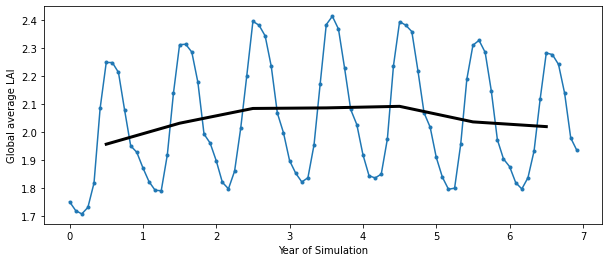

In [30]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, 
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']),
         '.-')
plt.plot(tyears,
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time'),
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average LAI')

# Look at land quantities in different latitudinal belts

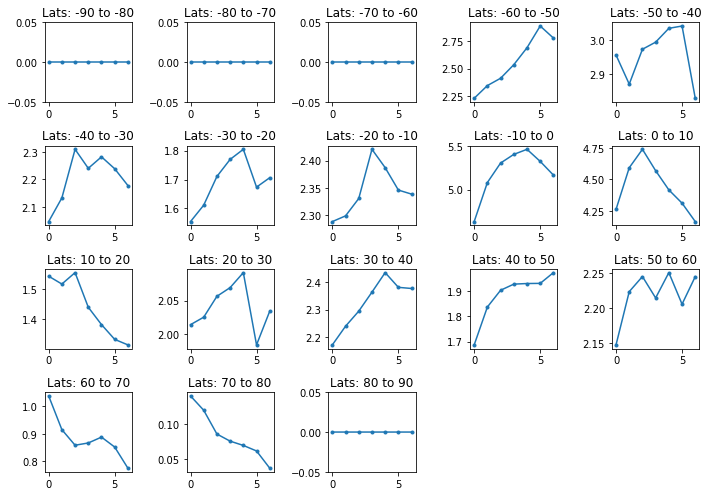

In [40]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    landweights_region=land_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_mean=(ds_lnd.TLAI*landweights_region).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time')
    plt.subplot(4,5,i+1)
    plt.plot(annual_mean,'.-')
    plt.title(label)
    if np.nanmax(annual_mean)<0.01:
        plt.ylim([-0.05,0.05])
    #plt.ylim([0,np.nanmax(annual_LAI)*1.2])
plt.tight_layout()

(-90.0, 90.0)

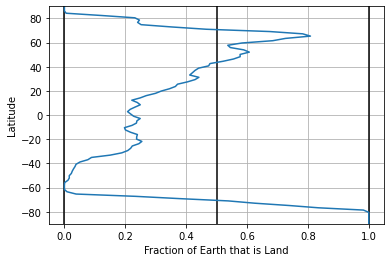

In [53]:
landfrac_full = ds_lnd.landfrac.fillna(0)
plt.plot([0,0],[-90,90],'-k')
plt.plot([0.5,0.5],[-90,90],'-k')
plt.plot([1,1],[-90,90],'-k')
plt.plot(landfrac_full.mean(dim='lon'),ds_lnd.lat)
plt.grid()
plt.xlabel('Fraction of Earth that is Land')
plt.ylabel('Latitude')
plt.ylim([-90,90])